In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [2]:
# Define the number of clients and the batch size for each client
num_clients = 25
batch_size = 1

# Check if CUDA (GPU) is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


In [5]:
# Load the training and testing data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Split the training data into num_clients number of subsets
train_data_split = torch.utils.data.random_split(train_data, [len(train_data)//num_clients]*num_clients)

# Define the model architecture and move it to the GPU
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

model = Net().to(device)

# Train the model on each client's subset of the data
def train_client(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

# Evaluate the model on the test data
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return test_loss, correct/len(test_loader.dataset)

# Initialize the model and the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model on each client's subset of the data
train_loss = []
train_acc = []
for epoch in range(25):
    for i in range(num_clients):
        train_loader = DataLoader(train_data_split[i], batch_size=batch_size, shuffle=True)
        train_client(model, train_loader, optimizer, epoch)

    # Evaluate the model on the test data after each epoch
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    test_loss, test_acc = test(model, test_loader)
    train_loss.append(test_loss)
    train_acc.append(test_acc)

    # Display the current training progress
    print(f'Epoch [{epoch+1}/25]: Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')



Epoch [1/25]: Test Loss: 0.1100, Test Accuracy: 0.9651
Epoch [2/25]: Test Loss: 0.0955, Test Accuracy: 0.9704
Epoch [3/25]: Test Loss: 0.0759, Test Accuracy: 0.9764
Epoch [4/25]: Test Loss: 0.0697, Test Accuracy: 0.9790
Epoch [5/25]: Test Loss: 0.0758, Test Accuracy: 0.9783
Epoch [6/25]: Test Loss: 0.0719, Test Accuracy: 0.9789
Epoch [7/25]: Test Loss: 0.0707, Test Accuracy: 0.9794
Epoch [8/25]: Test Loss: 0.0724, Test Accuracy: 0.9802
Epoch [9/25]: Test Loss: 0.0658, Test Accuracy: 0.9814
Epoch [10/25]: Test Loss: 0.0700, Test Accuracy: 0.9809
Epoch [11/25]: Test Loss: 0.0661, Test Accuracy: 0.9821
Epoch [12/25]: Test Loss: 0.0644, Test Accuracy: 0.9826
Epoch [13/25]: Test Loss: 0.0653, Test Accuracy: 0.9822
Epoch [14/25]: Test Loss: 0.0650, Test Accuracy: 0.9831
Epoch [15/25]: Test Loss: 0.0663, Test Accuracy: 0.9829
Epoch [16/25]: Test Loss: 0.0666, Test Accuracy: 0.9834
Epoch [17/25]: Test Loss: 0.0670, Test Accuracy: 0.9833
Epoch [18/25]: Test Loss: 0.0675, Test Accuracy: 0.9834
E

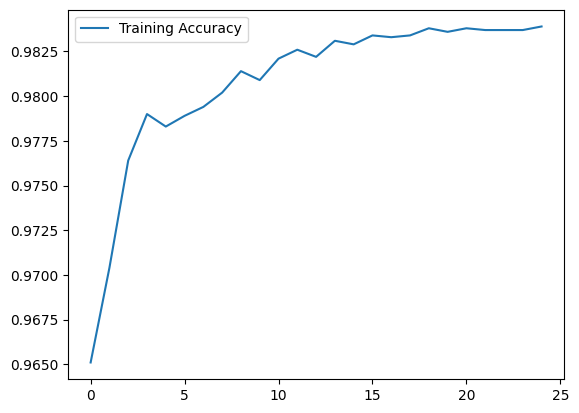

In [6]:
# Plot the training and testing accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.legend()
plt.show()